<a href="https://colab.research.google.com/github/KyonQi/RecommendationSystem/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Having a Try!

In [ ]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import annoy
import numpy as np
import pandas as pd
import torch
import os

In [ ]:
!git clone https://github.com/datawhalechina/torch-rechub.git

Cloning into 'torch-rechub'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (511/511), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 511 (delta 295), reused 486 (delta 293), pack-reused 0
Receiving objects: 100% (511/511), 221.27 KiB | 2.60 MiB/s, done.
Resolving deltas: 100% (295/295), done.


In [ ]:
%cd torch-rechub
!python setup.py install

`pd.set_option` is used for chaging the formation of displaying

`torch.manual_seed` is used for fixing the random seed, more convenient to repeat the outcome

In [ ]:
original_dir = '/content'
os.chdir(original_dir)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
torch.manual_seed(2022)

The example data csv is in ../content/torch-rechub/examples/matching/data/ml-1m/ml-1m_sample.csv

It is actually the top 100 samples picked from the original dataframe
for the need of testing

In [ ]:
#it's for testing
'''
data_path = '/content/torch-rechub/examples/matching/data/ml-1m/ml-1m_sample.csv'
data = pd.read_csv(data_path)
print(data.head()) # read the first 5 rows of data csv
'''


"\ndata_path = '/content/torch-rechub/examples/matching/data/ml-1m/ml-1m_sample.csv'\ndata = pd.read_csv(data_path)\nprint(data.head()) # read the first 5 rows of data csv\n"

### The whole data ml-1m


In [ ]:
whole_data_path_indrive = '../content/drive/MyDrive/ml-1m'
whole_data_path_local = '../content/ml-1m/original'
if not os.path.exists(whole_data_path_local):
  os.makedirs(whole_data_path_local)

In [ ]:
!cp  -r ../content/drive/MyDrive/ml-1m ../content/ml-1m/original

In [ ]:
def GenerateWholeCSV(original_data_dir):
  data_path = original_data_dir

  unames = ['user_id','gender','age','occupation','zip']
  user = pd.read_csv(data_path+'/ml-1m/users.dat',sep='::',header=None,names=unames, engine='python',encoding="ISO-8859-1")
  rnames = ['user_id','movie_id','rating','timestamp']
  ratings = pd.read_csv(data_path+'/ml-1m/ratings.dat',sep='::',header=None,names=rnames, engine='python',encoding="ISO-8859-1")
  mnames = ['movie_id','title','genres']
  movies = pd.read_csv(data_path+'/ml-1m/movies.dat',sep='::',header=None,names=mnames, engine='python',encoding="ISO-8859-1")

  data = pd.merge(pd.merge(ratings,movies),user)
  data.to_csv("../content/ml-1m/ml-1m.csv", index=False)

In [ ]:
GenerateWholeCSV(whole_data_path_local)

## data preprocessing

In [ ]:
data_path = '/content/data/ml-1m.csv'
data = pd.read_csv(data_path)
print(data.head())

   user_id  movie_id  rating  timestamp                                   title                        genres gender  age  occupation    zip
0        1      1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)                         Drama      F    1          10  48067
1        1       661       3  978302109        James and the Giant Peach (1996)  Animation|Children's|Musical      F    1          10  48067
2        1       914       3  978301968                     My Fair Lady (1964)               Musical|Romance      F    1          10  48067
3        1      3408       4  978300275                  Erin Brockovich (2000)                         Drama      F    1          10  48067
4        1      2355       5  978824291                    Bug's Life, A (1998)   Animation|Children's|Comedy      F    1          10  48067


In [ ]:
from sklearn.preprocessing import LabelEncoder

We'll preprocess the data so as to fit it in our model.

The main part is the preprocessing of features

We'll use the LabelEncoder to get a discrete number for features

In [ ]:
#using the first genre as a whole representation
data['genre_id'] = data['genres'].apply(lambda x: x.split('|')[0]) 

#print(data.head())

In [ ]:
user_col = 'user_id'
item_col = 'movie_id'
#using 'genre_id' instead of 'genres'
sparse_features = ['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip', 'genre_id']
dense_features = []

In [ ]:
save_dir = '../content/sample/data/movielen_1M/saved'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

Then we'll use LabelEncoder to get a discrete number for the sparse features

You could have some knowledge about `fit_transform` now

In [ ]:
print(data[sparse_features].head())
#for comparison

   user_id  movie_id gender  age  occupation    zip   genre_id
0        1      1193      F    1          10  48067      Drama
1        1       661      F    1          10  48067  Animation
2        1       914      F    1          10  48067    Musical
3        1      3408      F    1          10  48067      Drama
4        1      2355      F    1          10  48067  Animation


In [ ]:
feature_max_idx = {}
for feature in sparse_features:
  lbe = LabelEncoder()
  #generate the number from 1 but not 0
  data[feature] = lbe.fit_transform(data[feature]) + 1

  feature_max_idx[feature] = data[feature].max() + 1
  #print(data[feature].max())

  if feature == user_col:
    user_dict = {idx + 1: raw_id for idx, raw_id in enumerate(lbe.classes_)}
  if feature == item_col:
    item_dict = {idx + 1: raw_id for idx, raw_id in enumerate(lbe.classes_)}

np.save(save_dir + 'raw_id_dicts.npy', (user_dict, item_dict))

In [ ]:
print(data[sparse_features].head())

   user_id  movie_id  gender  age  occupation   zip  genre_id
0        1      1105       1    1          11  1589         8
1        1       640       1    1          11  1589         3
2        1       854       1    1          11  1589        12
3        1      3178       1    1          11  1589         8
4        1      2163       1    1          11  1589         3


Then we'll define the data we decide to throw into
the MLP

Typically, we'll divide it into two sides: one is
user_cols, and the other one is item_cols

In [ ]:
user_cols = ['user_id', 'gender', 'age', 'occupation', 'zip']
item_cols = ['movie_id', 'genre_id']

In [ ]:
print(data[user_cols].head())
print(data[item_cols].head())

   user_id  gender  age  occupation   zip
0        1       1    1          11  1589
1        1       1    1          11  1589
2        1       1    1          11  1589
3        1       1    1          11  1589
4        1       1    1          11  1589
   movie_id  genre_id
0      1105         8
1       640         3
2       854        12
3      3178         8
4      2163         3


Here it is necessary to get some knowledge about
`drop_duplicates` in Pandas

Remember what we want to do right now is to
get a profile of user or item

In [ ]:
user_profile = data[user_cols].drop_duplicates('user_id')
item_profile = data[item_cols].drop_duplicates('movie_id')
print(user_profile)
print(item_profile.head())

         user_id  gender  age  occupation   zip
0              1       1    1          11  1589
53             2       2    7          17  2249
182           12       2    3          13  1166
205           15       2    3           8   905
406           17       2    6           2  3188
...          ...     ...  ...         ...   ...
1000035     3537       2    1          11  3314
1000092     2908       2    2           3  2320
1000113     2982       2    3           5  1825
1000135     3893       2    3           7  2508
1000185     4211       2    5           6  2444

[6040 rows x 5 columns]
   movie_id  genre_id
0      1105         8
1       640         3
2       854        12
3      3178         8
4      2163         3


Here, we'll preprocess the data regarding of
the watching histories, which are represented by
'timestamp'



```
def generate_seq_feature_match(data, user_col, item_col,
time_col, item_attribute_cols=None, sample_method=0,
mode=0, neg_ratio=0, min_item=0):
"""
generate sequence feature and negative sample for match.
Args:
 data (pd.DataFrame): the raw data.
 user_col (str): the col name of user_id 
 item_col (str): the col name of item_id 
 time_col (str): the col name of timestamp
 item_attribute_cols (list[str], optional): the other attribute cols of item which you want to generate sequence feature. Defaults to `[]`.
 sample_method (int, optional): the negative sample method `{
 0: "random sampling", 
 1: "popularity sampling method used in word2vec", 
 2: "popularity sampling method by `log(count+1)+1e-6`",
 3: "tencent RALM sampling"}`. 
 Defaults to 0.
 mode (int, optional): the training mode, `{0:point-wise, 1:pair-wise, 2:list-wise}`. Defaults to 0.
 neg_ratio (int, optional): negative sample ratio, >= 1. Defaults to 0.
 min_item (int, optional): the min item each user must have. Defaults to 0.
 Returns:
  pd.DataFrame: split train and test data with sequence features.
"""
```



In [ ]:
import sys
sys.path.append('/content/torch-rechub/')
sys.path.append('/content/torch-rechub/examples/')
sys.path.append("../..")

In [ ]:
import sys
sys.path.append('/content/torch-rechub/')
from torch_rechub.utils.match import generate_seq_feature_match, gen_model_input

In [ ]:
train, test = generate_seq_feature_match(data, user_col, item_col, time_col='timestamp',
                      item_attribute_cols=[], sample_method=1, mode=0, 
                      neg_ratio=3, min_item=0)
print(train.head())
print(test.head())
x_train = gen_model_input(train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_train = x_train['label']
x_test = gen_model_input(test, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_test = x_test['label']
#print(x_train.items()) see the dataframe of x_train by this; it's actually a dict

preprocess data


generate sequence features: 100%|██████████| 6040/6040 [00:13<00:00, 455.00it/s]


n_train: 3952516, n_test: 6040
0 cold start user droped 
   user_id  movie_id                                      hist_movie_id  histlen_movie_id  label
0     1727      1280  [1140, 2856, 1788, 1179, 348, 1125, 1051, 2502...               451      0
1     3992      1274  [1782, 1108, 728, 153, 2558, 3399, 3342, 3504,...               142      0
2     2611      1902  [2634, 506, 1531, 580, 1486, 1382, 437, 465, 1...               395      0
3      929      2014  [347, 1282, 1105, 2312, 368, 1844, 2191, 1879,...               219      0
4     4376       597  [580, 2495, 467, 1429, 2886, 6, 1194, 584, 248...                31      0


In [ ]:
from torch_rechub.basic.features import SparseFeature, SequenceFeature
user_features = [SparseFeature(feature_name, vocab_size=feature_max_idx[feature_name], embed_dim=16) 
          for feature_name in user_cols]

user_features += [
    SequenceFeature('hist_movie_id', vocab_size=feature_max_idx['movie_id'],
            embed_dim=16, pooling='mean', shared_with='movie_id')
]

item_features = [
    SparseFeature(feature_name, vocab_size=feature_max_idx[feature_name], embed_dim=16)
    for feature_name in item_cols
]

print(user_features)
print(item_features)

[<SparseFeature user_id with Embedding shape (6041, 16)>, <SparseFeature gender with Embedding shape (3, 16)>, <SparseFeature age with Embedding shape (8, 16)>, <SparseFeature occupation with Embedding shape (22, 16)>, <SparseFeature zip with Embedding shape (3440, 16)>, <SequenceFeature hist_movie_id with Embedding shape (3707, 16)>]
[<SparseFeature movie_id with Embedding shape (3707, 16)>, <SparseFeature genre_id with Embedding shape (19, 16)>]


In [ ]:
from torch_rechub.utils.data import df_to_dict
all_item = df_to_dict(item_profile)
test_user = x_test

## model training

now we'll get a model and use the `x_train`
and `y_train` dicts to generate the data

Now we'll use DSSM model

MatchTrainer is a recalling container, which
is pre-defined in the library

In [ ]:
from torch_rechub.models.matching import DSSM
from torch_rechub.trainers import MatchTrainer
from torch_rechub.utils.data import MatchDataGenerator

In [ ]:
DataGenerator = MatchDataGenerator(x=x_train, y=y_train)
train_dataloader, test_dataloader, item_dataloader = DataGenerator.generate_dataloader(test_user, 
                                            all_item, batch_size=256)
model = DSSM(user_features, item_features, temperature=0.02, 
             user_params={'dims':[256, 128, 64],
                    'activation':'prelu'},
             item_params={'dims':[256, 128, 64],
                    'activation':'prelu'})
trainer = MatchTrainer(model, mode=0,
             optimizer_params={'lr':1e-4, 'weight_decay':1e-6},
             n_epoch=1, device='cuda:0', model_path=save_dir)

trainer.fit(train_dataloader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0


train: 100%|██████████| 15440/15440 [04:44<00:00, 54.35it/s, loss=0.559]


## Recalling

Now, we'll get the recalling and evaluating the
model



*   using `trainer` to get the users' embeddings and items' embeddings
*   using ANN to all users so as to recall K items
*   evaluating Top K




In [ ]:
import collections
from torch_rechub.utils.match import Annoy
from torch_rechub.basic.metric import topk_metrics

In [ ]:
def match_evaluation(user_embedding, item_embedding, test_user, all_item, user_col='user_id', item_col='movie_id',
                     raw_id_maps="../content/sample/data/movielen_1M/savedraw_id_dicts.npy", topk=10):
    print("evaluate embedding matching on test data")
    annoy = Annoy(n_trees=10)
    annoy.fit(item_embedding)

    #for each user of test dataset, get ann search topk result
    print("matching for topk")
    user_map, item_map = np.load(raw_id_maps, allow_pickle=True)
    match_res = collections.defaultdict(dict)  # user id -> predicted item ids
    for user_id, user_emb in zip(test_user[user_col], user_embedding):
        items_idx, items_scores = annoy.query(v=user_emb, n=topk)  #the index of topk match items
        match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][items_idx])

    #get ground truth
    print("generate ground truth")

    data = pd.DataFrame({user_col: test_user[user_col], item_col: test_user[item_col]})
    data[user_col] = data[user_col].map(user_map)
    data[item_col] = data[item_col].map(item_map)
    user_pos_item = data.groupby(user_col).agg(list).reset_index()
    ground_truth = dict(zip(user_pos_item[user_col], user_pos_item[item_col]))  # user id -> ground truth

    print("compute topk metrics")
    out = topk_metrics(y_true=ground_truth, y_pred=match_res, topKs=[topk])
    return out

In [ ]:
user_embedding = trainer.inference_embedding(model=model, mode="user", data_loader=test_dataloader, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode="item", data_loader=item_dataloader, model_path=save_dir)
match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=10, raw_id_maps='../content/sample/data/movielen_1M/savedraw_id_dicts.npy')

user inference:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
item inference: 100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


evaluate embedding matching on test data
matching for topk
generate ground truth
compute topk metrics


defaultdict(list,
            {'Hit': ['Hit@10: 0.0215'],
             'MRR': ['MRR@10: 0.0065'],
             'NDCG': ['NDCG@10: 0.0022'],
             'Precision': ['Precision@10: 0.0022'],
             'Recall': ['Recall@10: 0.0215']})

# YouTube DNN!

It's totally the same with having a try~

**Let's try it again**

## Prerequisite Libraries

In [ ]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import annoy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys

In [ ]:
!git clone https://github.com/datawhalechina/torch-rechub.git

fatal: destination path 'torch-rechub' already exists and is not an empty directory.


In [ ]:
%cd torch-rechub
!python setup.py install

In [ ]:
#def setup_seed(seed):
#  torch.manual_seed(seed)
#  torch.cuda.manual_seed_all(seed)
#  np.random.seed(seed)
#  torch.backends.cudnn.deterministic = True

#setup_seed(2022)

## Getting ml-1m.csv

In [ ]:
original_dir = '/content'
os.chdir(original_dir)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
torch.manual_seed(2022)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
whole_data_path_indrive = '../content/drive/MyDrive/ml-1m'
whole_data_path_local = '../content/ml-1m/original'
if not os.path.exists(whole_data_path_local):
  os.makedirs(whole_data_path_local)

In [ ]:
!cp  -r ../content/drive/MyDrive/ml-1m ../content/ml-1m/original

In [ ]:
def GenerateWholeCSV(original_data_dir):
  data_path = original_data_dir

  unames = ['user_id','gender','age','occupation','zip']
  user = pd.read_csv(data_path+'/ml-1m/users.dat',sep='::',header=None,names=unames, engine='python',encoding="ISO-8859-1")
  rnames = ['user_id','movie_id','rating','timestamp']
  ratings = pd.read_csv(data_path+'/ml-1m/ratings.dat',sep='::',header=None,names=rnames, engine='python',encoding="ISO-8859-1")
  mnames = ['movie_id','title','genres']
  movies = pd.read_csv(data_path+'/ml-1m/movies.dat',sep='::',header=None,names=mnames, engine='python',encoding="ISO-8859-1")

  data = pd.merge(pd.merge(ratings,movies),user)
  data.to_csv("../content/ml-1m/ml-1m.csv", index=False)

In [ ]:
GenerateWholeCSV(whole_data_path_local)

In [ ]:
data_path = '/content/ml-1m/ml-1m.csv'
data = pd.read_csv(data_path)
print(data.head())

   user_id  movie_id  rating  timestamp                                   title                        genres gender  age  occupation    zip
0        1      1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)                         Drama      F    1          10  48067
1        1       661       3  978302109        James and the Giant Peach (1996)  Animation|Children's|Musical      F    1          10  48067
2        1       914       3  978301968                     My Fair Lady (1964)               Musical|Romance      F    1          10  48067
3        1      3408       4  978300275                  Erin Brockovich (2000)                         Drama      F    1          10  48067
4        1      2355       5  978824291                    Bug's Life, A (1998)   Animation|Children's|Comedy      F    1          10  48067


## Data Preporcessing

In [ ]:
import sys
sys.path.append('/content/torch-rechub/')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch_rechub.trainers import MatchTrainer
from torch_rechub.basic.features import SparseFeature, SequenceFeature
from torch_rechub.utils.match import generate_seq_feature_match, gen_model_input
from torch_rechub.utils.data import df_to_dict, MatchDataGenerator
from torch_rechub.basic.layers import MLP, EmbeddingLayer

In [ ]:
save_dir = '/content/ml-1m/rawdata/'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

In [ ]:
data['cate_id'] = data['genres'].apply(lambda x: x.split('|')[0])
sparse_features = ['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip', 'cate_id']
user_col, item_col = 'user_id', 'movie_id'

In [ ]:
feature_max_idx = {} # it's a dict, describing the number of each feature
for feature in sparse_features:
  lbe = LabelEncoder()
  data[feature] = lbe.fit_transform(data[feature]) + 1 # starting from 1 instead of 0
  feature_max_idx[feature] = data[feature].max() + 1
  if feature == user_col:
    user_map = {encode_id + 1 : raw_id for encode_id, raw_id in enumerate(lbe.classes_)}
  if feature == item_col:
    item_map = {encode_id + 1 : raw_id for encode_id, raw_id in enumerate(lbe.classes_)}

np.save(save_dir + 'raw_id_maps.npy', (user_map, item_map))

In [ ]:
user_cols = ['gender', 'age', 'occupation', 'zip'] #not using user_id as user_cols
item_cols = ['movie_id', 'cate_id']
user_profile = data[ [user_col] + user_cols].drop_duplicates(user_col) #contains all the information of users
item_profile = data[item_cols].drop_duplicates(item_col) #contains all the information of items
print(user_profile.head())
print(item_profile.head())

     user_id  gender  age  occupation   zip
0          1       1    1          11  1589
53         2       2    7          17  2249
182       12       2    3          13  1166
205       15       2    3           8   905
406       17       2    6           2  3188
   movie_id  cate_id
0      1105        8
1       640        3
2       854       12
3      3178        8
4      2163        3


In [ ]:
df_train, df_test = generate_seq_feature_match(data, user_col, item_col, time_col='timestamp',
                         item_attribute_cols=[], sample_method=1, mode=2, 
                         neg_ratio=5, min_item=0) #generate the sequence feature based on timestamp
#print(df_train.head(),'\n',len(df_train))
x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
#print(x_train.keys())
del x_train[user_col] #as prof has said, user_id is not necessary for the input data
#print(x_train.keys())
y_train = np.array( [0] * df_train.shape[0] ) #[pos_sample, neg_sample, neg_sample, ..., neg_sample], so the label=0  it's a multi-task classification problem
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)
#del x_test[user_col]
#print(x_test.keys())

preprocess data


generate sequence features: 100%|██████████| 6040/6040 [00:14<00:00, 408.89it/s]


n_train: 988129, n_test: 6040
0 cold start user droped 


In [ ]:
user_sparse_features = [SparseFeature(name, vocab_size=feature_max_idx[name], embed_dim=32) for name in user_cols]
user_sequence_features = [SequenceFeature('hist_movie_id', vocab_size=feature_max_idx['movie_id'],
                      embed_dim=32, pooling='mean', shared_with='movie_id')]
user_features = user_sparse_features + user_sequence_features

#item_sparse_features = [SparseFeature(name, vocab_size=feature_max_idx[name], embed_dim=32) for name in item_cols] data could add a column with sequence of label
item_sparse_features = [SparseFeature('movie_id', vocab_size=feature_max_idx['movie_id'], embed_dim=32)]
item_sequence_features = []
item_features = item_sparse_features + item_sequence_features

neg_item_features = [SequenceFeature('neg_items', vocab_size=feature_max_idx['movie_id'], embed_dim=32,
                    pooling='concat', shared_with='movie_id')]

## Training

In [ ]:
import collections
import numpy as np
import pandas as pd
from torch_rechub.utils.match import Annoy
from torch_rechub.basic.metric import topk_metrics
from collections import Counter


def match_evaluation(user_embedding, item_embedding, test_user, all_item, user_col='user_id', item_col='movie_id',
                     raw_id_maps="./data/ml-1m/saved/raw_id_maps.npy", topk=10):
    print("evaluate embedding matching on test data")
    annoy = Annoy(n_trees=10)
    annoy.fit(item_embedding)

    #for each user of test dataset, get ann search topk result
    print("matching for topk")
    user_map, item_map = np.load(raw_id_maps, allow_pickle=True)
    match_res = collections.defaultdict(dict)  # user id -> predicted item ids
    for user_id, user_emb in zip(test_user[user_col], user_embedding):
        if len(user_emb.shape)==2:
            #多兴趣召回
            items_idx = []
            items_scores = []
            for i in range(user_emb.shape[0]):
                temp_items_idx, temp_items_scores = annoy.query(v=user_emb[i], n=topk)  # the index of topk match items
                items_idx += temp_items_idx
                items_scores += temp_items_scores
            temp_df = pd.DataFrame()
            temp_df['item'] = items_idx
            temp_df['score'] = items_scores
            temp_df = temp_df.sort_values(by='score', ascending=True)
            temp_df = temp_df.drop_duplicates(subset=['item'], keep='first', inplace=False)
            recall_item_list = temp_df['item'][:topk].values
            match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][recall_item_list])
        else:
            #普通召回
            items_idx, items_scores = annoy.query(v=user_emb, n=topk)  #the index of topk match items
            match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][items_idx])

    #get ground truth
    print("generate ground truth")

    data = pd.DataFrame({user_col: test_user[user_col], item_col: test_user[item_col]})
    data[user_col] = data[user_col].map(user_map)
    data[item_col] = data[item_col].map(item_map)
    user_pos_item = data.groupby(user_col).agg(list).reset_index()
    ground_truth = dict(zip(user_pos_item[user_col], user_pos_item[item_col]))  # user id -> ground truth

    print("compute topk metrics")
    out = topk_metrics(y_true=ground_truth, y_pred=match_res, topKs=[topk])
    print(out)
    return out, match_res, ground_truth

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch_rechub.models.matching import YoutubeDNN
from torch_rechub.trainers import MatchTrainer
from torch_rechub.basic.features import SparseFeature, SequenceFeature
from torch_rechub.utils.match import generate_seq_feature_match, gen_model_input
from torch_rechub.utils.data import df_to_dict, MatchDataGenerator
all_item = df_to_dict(item_profile)
test_user = x_test

dg = MatchDataGenerator(x=x_train, y=y_train) #This dataloader class can be optimized better; it's not understandable and convenient enough
train_dl, test_dl, item_dl = dg.generate_dataloader(test_user, all_item, batch_size=256, num_workers=2)

model = YoutubeDNN(user_features, item_features, neg_item_features, user_params={"dims": [128, 256, 128, 64, 32]}, temperature=0.02)  # [4] MLP的最后一层需保持与item embedding一致

#mode=1 means pair-wise learning
trainer = MatchTrainer(model,
             mode=2,
             optimizer_params={
                      "lr": 1e-4,
                      "weight_decay": 1e-6
                      },
             n_epoch=10, #5
             device='cuda:0',
             model_path=save_dir)

trainer.fit(train_dl)

print("inference embedding")
user_embedding = trainer.inference_embedding(model=model, mode="user", data_loader=test_dl, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode="item", data_loader=item_dl, model_path=save_dir)


epoch: 0


train: 100%|██████████| 3860/3860 [01:12<00:00, 53.45it/s, loss=2.11]


epoch: 1


train: 100%|██████████| 3860/3860 [01:03<00:00, 61.20it/s, loss=1.57]


epoch: 2


train: 100%|██████████| 3860/3860 [01:03<00:00, 61.04it/s, loss=1.4]


epoch: 3


train: 100%|██████████| 3860/3860 [01:15<00:00, 50.90it/s, loss=1.28]


epoch: 4


train: 100%|██████████| 3860/3860 [01:02<00:00, 61.29it/s, loss=1.19]


epoch: 5


train: 100%|██████████| 3860/3860 [01:01<00:00, 62.33it/s, loss=1.14]


epoch: 6


train: 100%|██████████| 3860/3860 [01:03<00:00, 61.06it/s, loss=1.1]


epoch: 7


train: 100%|██████████| 3860/3860 [01:01<00:00, 62.47it/s, loss=1.01]


epoch: 8


train: 100%|██████████| 3860/3860 [01:03<00:00, 61.21it/s, loss=0.991]


epoch: 9


train: 100%|██████████| 3860/3860 [01:01<00:00, 62.44it/s, loss=1]


inference embedding


item inference: 100%|██████████| 15/15 [00:00<00:00, 57.77it/s]


In [ ]:
#metric_dict_1 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=100, raw_id_maps=save_dir+"raw_id_maps.npy")
#metric_dict_2 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=50, raw_id_maps=save_dir+"raw_id_maps.npy")
#metric_dict_3 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=10, raw_id_maps=save_dir+"raw_id_maps.npy")
#metric_dict_4 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=5, raw_id_maps=save_dir+"raw_id_maps.npy")
metric_dict_5, y_pred_YDNN_3, y_truth_YDNN_3 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=3, raw_id_maps=save_dir+"raw_id_maps.npy")
#print(metric_dict_1,'\n','------------------','\n',metric_dict_2,'\n','------------------','\n',metric_dict_3,'\n','------------------','\n',metric_dict_4,'\n','------------------','\n',metric_dict_5)

evaluate embedding matching on test data
matching for topk
generate ground truth
compute topk metrics
defaultdict(<class 'list'>, {'NDCG': ['NDCG@3: 0.004'], 'MRR': ['MRR@3: 0.0074'], 'Recall': ['Recall@3: 0.0123'], 'Hit': ['Hit@3: 0.0123'], 'Precision': ['Precision@3: 0.0041']})


In [ ]:
y_pred_YDNN_3[2], y_truth_YDNN_3[2]

(array([1479,  379, 1004]), [1687])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
'''
loss = [1.67,
1.38,
1.21,
1.11,
1.04,
0.965,
0.936,
0.916,
0.884,
0.875,
0.854,
0.835,
0.861,
0.845,
0.804,
0.794,
0.794,
0.797,
0.793,
0.771,
0.784,
0.791,
0.786,
0.767,
0.77,
0.711,
0.748,
0.752,
0.756,
0.742,
0.76,
0.732,
0.758,
0.715,
0.759,
0.7,
0.718,
0.712,
0.732,
0.743,
0.716,
0.728,
0.703,
0.73,
0.72,
0.684,
0.676,
0.675,
0.742,
0.697,
0.681,
0.694,
0.642,
0.645,
0.685,
0.693,
0.675,
0.69,
0.676,
0.671,
0.694,
0.656,
0.687,
0.65,
0.654,
0.7,
0.674,
0.658,
0.651,
0.664,
0.657,
0.685,
0.692,
0.636,
0.675,
0.656,
0.659,
0.649,
0.626,
0.653,
0.646,
0.653,
0.685,
0.65,
0.648,
0.651,
0.632,
0.655,
0.652,
0.661,
0.621,
0.638,
0.657,
0.621,
0.634,
0.649,
0.637,
0.627,
0.629,
0.651]
x = [i for i in range(len(loss))]
'''

'\nloss = [1.67,\n1.38,\n1.21,\n1.11,\n1.04,\n0.965,\n0.936,\n0.916,\n0.884,\n0.875,\n0.854,\n0.835,\n0.861,\n0.845,\n0.804,\n0.794,\n0.794,\n0.797,\n0.793,\n0.771,\n0.784,\n0.791,\n0.786,\n0.767,\n0.77,\n0.711,\n0.748,\n0.752,\n0.756,\n0.742,\n0.76,\n0.732,\n0.758,\n0.715,\n0.759,\n0.7,\n0.718,\n0.712,\n0.732,\n0.743,\n0.716,\n0.728,\n0.703,\n0.73,\n0.72,\n0.684,\n0.676,\n0.675,\n0.742,\n0.697,\n0.681,\n0.694,\n0.642,\n0.645,\n0.685,\n0.693,\n0.675,\n0.69,\n0.676,\n0.671,\n0.694,\n0.656,\n0.687,\n0.65,\n0.654,\n0.7,\n0.674,\n0.658,\n0.651,\n0.664,\n0.657,\n0.685,\n0.692,\n0.636,\n0.675,\n0.656,\n0.659,\n0.649,\n0.626,\n0.653,\n0.646,\n0.653,\n0.685,\n0.65,\n0.648,\n0.651,\n0.632,\n0.655,\n0.652,\n0.661,\n0.621,\n0.638,\n0.657,\n0.621,\n0.634,\n0.649,\n0.637,\n0.627,\n0.629,\n0.651]\nx = [i for i in range(len(loss))]\n'

In [ ]:
'''
plt.figure(figsize=(10, 5))
plt.plot(x, loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('ML-1M YouTubeDNN')
plt.savefig('loss.png')
plt.show()
'''

"\nplt.figure(figsize=(10, 5))\nplt.plot(x, loss)\nplt.xlabel('Epoch')\nplt.ylabel('Training Loss')\nplt.title('ML-1M YouTubeDNN')\nplt.savefig('loss.png')\nplt.show()\n"

# YDNNA in MovieLen

## Prerequisite Libraries

In [ ]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 7.8 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395181 sha256=3b63638298c6fe401c75becf2a2fde6df07e1206c9890dfc7d6f646640c255d7
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [ ]:
import annoy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys

In [ ]:
!git clone https://github.com/datawhalechina/torch-rechub.git
sys.path.append('/content/torch-rechub/')
% cd torch-rechub
!python setup.py install

Cloning into 'torch-rechub'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 530 (delta 308), reused 504 (delta 306), pack-reused 0
Receiving objects: 100% (530/530), 226.82 KiB | 7.32 MiB/s, done.
Resolving deltas: 100% (308/308), done.
/content/torch-rechub
running install
running bdist_egg
running egg_info
creating torch_rechub.egg-info
writing torch_rechub.egg-info/PKG-INFO
writing dependency_links to torch_rechub.egg-info/dependency_links.txt
writing requirements to torch_rechub.egg-info/requires.txt
writing top-level names to torch_rechub.egg-info/top_level.txt
writing manifest file 'torch_rechub.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'torch_rechub.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/torch_rechub
copying torch_

For the repeat of the experiment, we'll fix our random seed

In [ ]:
#def setup_seed(seed):
#  torch.manual_seed(seed)
#  torch.cuda.manual_seed_all(seed)
#  np.random.seed(seed)
#  torch.backends.cudnn.deterministic = True

#setup_seed(2022)

## Getting ml-1m.csv

In [ ]:
original_dir = '/content'
os.chdir(original_dir)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
whole_data_path_indrive = '../content/drive/MyDrive/ml-1m'
whole_data_path_local = '../content/ml-1m/original'
if not os.path.exists(whole_data_path_local):
  os.makedirs(whole_data_path_local)

In [ ]:
!cp  -r ../content/drive/MyDrive/ml-1m ../content/ml-1m/original

In [ ]:
def GenerateWholeCSV(original_data_dir):
  data_path = original_data_dir

  unames = ['user_id','gender','age','occupation','zip']
  user = pd.read_csv(data_path+'/ml-1m/users.dat',sep='::',header=None,names=unames, engine='python',encoding="ISO-8859-1")
  rnames = ['user_id','movie_id','rating','timestamp']
  ratings = pd.read_csv(data_path+'/ml-1m/ratings.dat',sep='::',header=None,names=rnames, engine='python',encoding="ISO-8859-1")
  mnames = ['movie_id','title','genres']
  movies = pd.read_csv(data_path+'/ml-1m/movies.dat',sep='::',header=None,names=mnames, engine='python',encoding="ISO-8859-1")

  data = pd.merge(pd.merge(ratings,movies),user)
  data.to_csv("../content/ml-1m/ml-1m.csv", index=False)

GenerateWholeCSV(whole_data_path_local)

In [ ]:
data_path = '/content/ml-1m/ml-1m.csv'
data = pd.read_csv(data_path)
print(data.head())

   user_id  movie_id  rating  timestamp                                   title                        genres gender  age  occupation    zip
0        1      1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)                         Drama      F    1          10  48067
1        1       661       3  978302109        James and the Giant Peach (1996)  Animation|Children's|Musical      F    1          10  48067
2        1       914       3  978301968                     My Fair Lady (1964)               Musical|Romance      F    1          10  48067
3        1      3408       4  978300275                  Erin Brockovich (2000)                         Drama      F    1          10  48067
4        1      2355       5  978824291                    Bug's Life, A (1998)   Animation|Children's|Comedy      F    1          10  48067


In [ ]:
# for experiment, we first use sample data instead
#data_path = '/content/torch-rechub/examples/matching/data/ml-1m/ml-1m_sample.csv'
#data = pd.read_csv(data_path)
#print(data.head(), '\n', len(data))


## Data Preporcessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch_rechub.trainers import MatchTrainer
from torch_rechub.basic.features import SparseFeature, SequenceFeature
from torch_rechub.utils.match import generate_seq_feature_match, gen_model_input
from torch_rechub.utils.data import df_to_dict, MatchDataGenerator
from torch_rechub.basic.layers import MLP, EmbeddingLayer

In [ ]:
save_dir = '/content/ml-1m/rawdata/'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

In [ ]:
data['cate_id'] = data['genres'].apply(lambda x: x.split('|')[0])
sparse_features = ['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip', 'cate_id']
user_col, item_col = 'user_id', 'movie_id'

In [ ]:
feature_max_idx = {} # it's a dict, describing the number of each feature
for feature in sparse_features:
  lbe = LabelEncoder()
  data[feature] = lbe.fit_transform(data[feature]) + 1 # starting from 1 instead of 0
  feature_max_idx[feature] = data[feature].max() + 1
  if feature == user_col:
    user_map = {encode_id + 1 : raw_id for encode_id, raw_id in enumerate(lbe.classes_)}
  if feature == item_col:
    item_map = {encode_id + 1 : raw_id for encode_id, raw_id in enumerate(lbe.classes_)}

np.save(save_dir + 'raw_id_maps.npy', (user_map, item_map))

In [ ]:
user_cols = ['gender', 'age', 'occupation', 'zip'] #not using user_id as user_cols
item_cols = ['movie_id', 'cate_id']
user_profile = data[ [user_col] + user_cols].drop_duplicates(user_col) #contains all the information of users
item_profile = data[item_cols].drop_duplicates(item_col) #contains all the information of items
print(user_profile.head())
print(item_profile.head())

     user_id  gender  age  occupation   zip
0          1       1    1          11  1589
53         2       2    7          17  2249
182       12       2    3          13  1166
205       15       2    3           8   905
406       17       2    6           2  3188
   movie_id  cate_id
0      1105        8
1       640        3
2       854       12
3      3178        8
4      2163        3


In [ ]:
df_train, df_test = generate_seq_feature_match(data, user_col, item_col, time_col='timestamp',
                         item_attribute_cols=[], sample_method=1, mode=2, 
                         neg_ratio=5, min_item=0) #generate the sequence feature based on timestamp
#print(df_train.head(),'\n',len(df_train))
x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
#print(x_train.keys())
del x_train[user_col] #as prof has said, user_id is not necessary for the input data
#print(x_train.keys())
y_train = np.array( [0] * df_train.shape[0] ) #[pos_sample, neg_sample, neg_sample, ..., neg_sample], so the label=0  it's a multi-task classification problem
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)
#del x_test[user_col]
#print(x_test.keys())

preprocess data


generate sequence features: 100%|██████████| 6040/6040 [00:09<00:00, 611.20it/s] 


n_train: 988129, n_test: 6040
0 cold start user droped 


## YDNNA Model Constructing

Firstly, we'll get the feature dimension for embedding layer

Generally, we have


*   user_features (Sparse + Sequence)
*   item_features (Sparse + Sequence)
*   neg_item_features (Sequence)



In [ ]:
user_sparse_features = [SparseFeature(name, vocab_size=feature_max_idx[name], embed_dim=32) for name in user_cols]
user_sequence_features = [SequenceFeature('hist_movie_id', vocab_size=feature_max_idx['movie_id'],
                      embed_dim=32, pooling='concat', shared_with='movie_id')]
user_features = user_sparse_features + user_sequence_features

#item_sparse_features = [SparseFeature(name, vocab_size=feature_max_idx[name], embed_dim=32) for name in item_cols] data could add a column with sequence of label
item_sparse_features = [SparseFeature('movie_id', vocab_size=feature_max_idx['movie_id'], embed_dim=32)]
item_sequence_features = []
item_features = item_sparse_features + item_sequence_features

neg_item_features = [SequenceFeature('neg_items', vocab_size=feature_max_idx['movie_id'], embed_dim=32,
                    pooling='concat', shared_with='movie_id')]

In [ ]:
print(user_features,'\n',item_features,'\n',neg_item_features)
print(len(user_features))
#print(32*len(item_features))

[<SparseFeature gender with Embedding shape (3, 32)>, <SparseFeature age with Embedding shape (8, 32)>, <SparseFeature occupation with Embedding shape (22, 32)>, <SparseFeature zip with Embedding shape (3440, 32)>, <SequenceFeature hist_movie_id with Embedding shape (3707, 32)>] 
 [<SparseFeature movie_id with Embedding shape (3707, 32)>] 
 [<SequenceFeature neg_items with Embedding shape (3707, 32)>]
5


Now, we'll build our DIN model based on YouTube DNN

It means that the item tower would not inroduce MLP structure

Now, we build the ActivationUnit first

In [ ]:
class ActivationUnit(nn.Module):
    """Activation Unit Layer mentioned in DIN paper, it is a Target Attention method.

    Args:
        embed_dim (int): the length of embedding vector.
        history (tensor):
    Shape:
        - Input: `(batch_size, seq_length, emb_dim)`
        - Output: `(batch_size, emb_dim)`
    """

    def __init__(self, emb_dim, dims=None, activation="dice", use_softmax=False):
        super(ActivationUnit, self).__init__()
        if dims is None:
            dims = [36] # just like the origin paper DIN`
        self.emb_dim = emb_dim
        self.use_softmax = use_softmax
        self.attention = MLP(4 * self.emb_dim, dims=dims, activation=activation) # output_layer=True is default set

    def forward(self, history, target):
        seq_length = history.size(1)
        target = target.unsqueeze(1).expand(-1, seq_length, -1)  #batch_size,seq_length,emb_dim
        att_input = torch.cat([target, history, target - history, target * history],
                              dim=-1)  # batch_size,seq_length,4*emb_dim[p=]
        att_weight = self.attention(att_input.view(-1, 4 * self.emb_dim))  #  #(batch_size*seq_length,4*emb_dim)
        att_weight = att_weight.view(-1, seq_length)  #(batch_size*seq_length, 1) -> (batch_size,seq_length)
        if self.use_softmax:
            att_weight = att_weight.softmax(dim=-1)
        # (batch_size, seq_length, 1) * (batch_size, seq_length, emb_dim)
        output = (att_weight.unsqueeze(-1) * history).sum(dim=1)  #(batch_size,emb_dim)
        return output

Then, we could have our YDNNA model

In [ ]:
class YDNNA(torch.nn.Module):
    """
    It's a model modified from YouTube DNN, which adds attention mechanism in it
    It's a DSSM match model trained by global softmax loss on list-wise samples.
    Note in origin paper, it's without item dnn tower and train item embedding directly.

    Args:
        user_features (list[Feature Class]): training by the user tower module.
        item_features (list[Feature Class]): training by the embedding table, it's the item id feature.
        neg_item_feature (list[Feature Class]): training by the embedding table, it's the negative items id feature.
        user_params (dict): the params of the User Tower module, keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
        attention_mlp_params (dict): the params of the attention MLP structure, keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}
        temperature (float): temperature factor for similarity score, default to 1.0.
    """

    def __init__(self, user_features, item_features, neg_item_feature, user_params, attention_mlp_params={"dims": [256, 128]}, temperature=1.0):
        super().__init__()
        self.user_features = user_features
        self.item_features = item_features
        self.neg_item_feature = neg_item_feature

        self.user_sequence_features = []
        self.user_sparse_features = []
        for fea in user_features:
          if isinstance(fea, SequenceFeature):
            self.user_sequence_features.append(fea)
          if isinstance(fea, SparseFeature):
            self.user_sparse_features.append(fea)
        #for fea in item_features: # as for now, we don't have any data of it
        #  if isinstance(fea, SequenceFeature):
        #    self.item_sequence_features += fea
        self.num_sequence_features = len(self.user_sequence_features)
        self.num_sparse_features = len(self.user_sparse_features)

        self.temperature = temperature
        self.user_dims = sum([fea.embed_dim for fea in user_features]) #for MLP input dimension
        self.embedding = EmbeddingLayer(user_features + item_features)

        self.attention_layers = nn.ModuleList([ActivationUnit(fea.embed_dim, **attention_mlp_params) for fea in self.user_sequence_features])

        self.user_mlp = MLP(self.user_dims, output_layer=False, **user_params, activation='dice',)
        self.mode = None

    def forward(self, x):
        user_embedding = self.user_tower(x)
        item_embedding = self.item_tower(x)
        if self.mode == "user":
            return user_embedding
        if self.mode == "item":
            return item_embedding

        # calculate cosine score
        y = torch.mul(user_embedding, item_embedding).sum(dim=2)
        y = y / self.temperature
        return y

    def user_tower(self, x):
        if self.mode == "item":
            return None
#------------------------------
#attention mechanism
        user_sparse_embedding = self.embedding(x, self.user_sparse_features)
        user_sequence_embedding = self.embedding(x, self.user_sequence_features)
        pos_item_embedding = self.embedding(x, self.item_features)
        pos_item_embedding = F.normalize(pos_item_embedding, p=2, dim=2)
        attention_pooling = []
        for i in range(self.num_sequence_features):
          attention_seq = self.attention_layers[i](user_sequence_embedding[:, i, :, :], pos_item_embedding[:, i, :])
          attention_pooling.append(attention_seq.unsqueeze(1)) #(batch_size, 1, emb_dim)
        attention_pooling = torch.cat(attention_pooling, dim=1) #(batch_size, num_sequence_features, emb_dim)
        input_user = torch.cat([user_sparse_embedding.flatten(start_dim=1), attention_pooling.flatten(start_dim=1)], dim=1) #(batch_size, N)
#------------------------------
        #input_user = self.embedding(x, self.user_features, squeeze_dim=True)  #[batch_size, num_features*deep_dims]
        user_embedding = self.user_mlp(input_user).unsqueeze(1)  #[batch_size, 1, embed_dim]
        user_embedding = F.normalize(user_embedding, p=2, dim=2)
        if self.mode == "user":
            return user_embedding.squeeze(1)  #inference embedding mode -> [batch_size, embed_dim]
        return user_embedding

    def item_tower(self, x):
        if self.mode == "user":
            return None
        pos_embedding = self.embedding(x, self.item_features, squeeze_dim=False)  #[batch_size, 1, embed_dim]
        pos_embedding = F.normalize(pos_embedding, p=2, dim=2)
        #pos_embedding = pos_embedding.flatten(start_dim=1)
        #pos_embedding = pos_embedding.unsqueeze(dim=1)
        pos_embedding = pos_embedding.mean(dim=1)
        pos_embedding = pos_embedding.unsqueeze(dim=1)
        #print(pos_embedding.size())
        if self.mode == "item":  #inference embedding mode
            return pos_embedding.squeeze(1)  #[batch_size, embed_dim]
        neg_embeddings = self.embedding(x, self.neg_item_feature,
                                        squeeze_dim=False).squeeze(1)  #[batch_size, n_neg_items, embed_dim]
        neg_embeddings = F.normalize(neg_embeddings, p=2, dim=2)
        #print('neg:', neg_embeddings.size())
        return torch.cat((pos_embedding, neg_embeddings), dim=1)  #[batch_size, 1+n_neg_items, embed_dim]

## Training

In [ ]:
import collections
import numpy as np
import pandas as pd
from torch_rechub.utils.match import Annoy
from torch_rechub.basic.metric import topk_metrics
from collections import Counter


def match_evaluation(user_embedding, item_embedding, test_user, all_item, user_col='user_id', item_col='movie_id',
                     raw_id_maps="./data/ml-1m/saved/raw_id_maps.npy", topk=10):
    print("evaluate embedding matching on test data")
    annoy = Annoy(n_trees=10)
    annoy.fit(item_embedding)

    #for each user of test dataset, get ann search topk result
    print("matching for topk")
    user_map, item_map = np.load(raw_id_maps, allow_pickle=True)
    match_res = collections.defaultdict(dict)  # user id -> predicted item ids
    for user_id, user_emb in zip(test_user[user_col], user_embedding):
        if len(user_emb.shape)==2:
            #多兴趣召回
            items_idx = []
            items_scores = []
            for i in range(user_emb.shape[0]):
                temp_items_idx, temp_items_scores = annoy.query(v=user_emb[i], n=topk)  # the index of topk match items
                items_idx += temp_items_idx
                items_scores += temp_items_scores
            temp_df = pd.DataFrame()
            temp_df['item'] = items_idx
            temp_df['score'] = items_scores
            temp_df = temp_df.sort_values(by='score', ascending=True)
            temp_df = temp_df.drop_duplicates(subset=['item'], keep='first', inplace=False)
            recall_item_list = temp_df['item'][:topk].values
            match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][recall_item_list])
        else:
            #普通召回
            items_idx, items_scores = annoy.query(v=user_emb, n=topk)  #the index of topk match items
            match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][items_idx])

    #get ground truth
    print("generate ground truth")

    data = pd.DataFrame({user_col: test_user[user_col], item_col: test_user[item_col]})
    data[user_col] = data[user_col].map(user_map)
    data[item_col] = data[item_col].map(item_map)
    user_pos_item = data.groupby(user_col).agg(list).reset_index()
    ground_truth = dict(zip(user_pos_item[user_col], user_pos_item[item_col]))  # user id -> ground truth

    print("compute topk metrics")
    out = topk_metrics(y_true=ground_truth, y_pred=match_res, topKs=[topk])
    print(out)
    return out, match_res, ground_truth

In [ ]:
all_item = df_to_dict(item_profile)
test_user = x_test

dg = MatchDataGenerator(x=x_train, y=y_train) #This dataloader class can be optimized better; it's not understandable and convenient enough
train_dl, test_dl, item_dl = dg.generate_dataloader(test_user, all_item, batch_size=256, num_workers=2)

model = YDNNA(user_features, item_features, neg_item_features, user_params={"dims": [128, 256, 128, 64, 32]}, attention_mlp_params={"dims": [256, 128]}, temperature=0.02) # it's not defined yet

trainer = MatchTrainer(model, mode=2, optimizer_params={'lr': 1e-4, 'weight_decay': 1e-6},
             n_epoch=10, device='cuda:0', model_path=save_dir)
trainer.fit(train_dl)

print('inference embedding')
user_embedding = trainer.inference_embedding(model=model, mode='user', data_loader=test_dl, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode='item', data_loader=item_dl, model_path=save_dir)

epoch: 0


train: 100%|██████████| 3860/3860 [01:56<00:00, 33.04it/s, loss=0.279]


epoch: 1


train: 100%|██████████| 3860/3860 [01:53<00:00, 34.06it/s, loss=0.222]


epoch: 2


train: 100%|██████████| 3860/3860 [01:52<00:00, 34.18it/s, loss=0.15]


epoch: 3


train: 100%|██████████| 3860/3860 [01:59<00:00, 32.25it/s, loss=0.0978]


epoch: 4


train: 100%|██████████| 3860/3860 [01:54<00:00, 33.72it/s, loss=0.0797]


epoch: 5


train: 100%|██████████| 3860/3860 [01:52<00:00, 34.37it/s, loss=0.0541]


epoch: 6


train: 100%|██████████| 3860/3860 [01:52<00:00, 34.42it/s, loss=0.0502]


epoch: 7


train: 100%|██████████| 3860/3860 [01:51<00:00, 34.49it/s, loss=0.0345]


epoch: 8


train: 100%|██████████| 3860/3860 [01:51<00:00, 34.53it/s, loss=0.025]


epoch: 9


train: 100%|██████████| 3860/3860 [01:56<00:00, 33.00it/s, loss=0.0191]


inference embedding


item inference: 100%|██████████| 15/15 [00:00<00:00, 83.65it/s]


In [ ]:
metric_dict, y_pred, y_truth = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=10, raw_id_maps=save_dir+"raw_id_maps.npy")

evaluate embedding matching on test data
matching for topk
generate ground truth
compute topk metrics
defaultdict(<class 'list'>, {'NDCG': ['NDCG@10: 0.1061'], 'MRR': ['MRR@10: 0.3953'], 'Recall': ['Recall@10: 0.7606'], 'Hit': ['Hit@10: 0.7606'], 'Precision': ['Precision@10: 0.0761']})


In [ ]:
#metric_dict_1 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=100, raw_id_maps=save_dir+"raw_id_maps.npy")
#metric_dict_2 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=50, raw_id_maps=save_dir+"raw_id_maps.npy")
#metric_dict_3 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=10, raw_id_maps=save_dir+"raw_id_maps.npy")
#metric_dict_4 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=5, raw_id_maps=save_dir+"raw_id_maps.npy")
metric_dict_5, y_predict_3, y_truth_3 = match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=3, raw_id_maps=save_dir+"raw_id_maps.npy")
#print(metric_dict_1,'\n','------------------',metric_dict_2,'\n','------------------','\n',metric_dict_3,'\n','------------------','\n',metric_dict_4,'\n','------------------','\n',metric_dict_5)

evaluate embedding matching on test data
matching for topk
generate ground truth
compute topk metrics
defaultdict(<class 'list'>, {'NDCG': ['NDCG@3: 0.1715'], 'MRR': ['MRR@3: 0.3342'], 'Recall': ['Recall@3: 0.456'], 'Hit': ['Hit@3: 0.456'], 'Precision': ['Precision@3: 0.152']})


## Ground Truth


In [ ]:
y_pred[1], y_truth[1]

(array([  69, 2622,   48, 3310,  112, 2763, 3275, 2482, 2625,  359]), [48])

In [ ]:
y_predict_3[2], y_truth_3[2]

(array([ 362, 1687, 2568]), [1687])

## Loss Comparison

In [ ]:
loss_attention = [0.485, 0.314, 0.185, 0.115, 0.0649, 0.0504, 0.0465, 0.0333, 0.0261, 0.0215]
loss_original = [2.05, 1.57, 1.39, 1.32, 1.14, 1.13, 1.07, 1.06, 1.02, 0.987]

In [ ]:
'''
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
x = np.arange(1, 11)
ax.plot(x, loss_attention, label='YDNNA')
ax.plot(x, loss_original, label='YouTubeDNN')
ax.set_xlabel('Epoch')
ax.set_xlim(1, 10)
ax.set_ylabel('Loss')
ax.set_title('Loss Comparison')
ax.legend()
plt.savefig('Loss Comparison')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport numpy as np\nplt.figure(figsize=(10, 8))\nfig, ax = plt.subplots()\nx = np.arange(1, 11)\nax.plot(x, loss_attention, label='YDNNA')\nax.plot(x, loss_original, label='YouTubeDNN')\nax.set_xlabel('Epoch')\nax.set_xlim(1, 10)\nax.set_ylabel('Loss')\nax.set_title('Loss Comparison')\nax.legend()\nplt.savefig('Loss Comparison')\nplt.show()\n"

# Rough Poster


## YouTubeDNN Loss

In [ ]:
import numpy as np
YDNN_loss_1 = [1.98, 1.54, 1.4, 1.24, 1.18, 1.06, 1.01, 1.04, 0.955, 0.965]
YDNN_loss_2 = [1.97, 1.6, 1.37, 1.2, 1.15, 1.04, 1.04, 1.01, 0.992, 0.957]
YDNN_loss_3 = [1.97, 1.6, 1.37, 1.2, 1.15, 1.04, 1.04, 1.01, 0.992, 0.957]
YDNN_loss_4 = [2.13, 1.68, 1.42, 1.3, 1.18, 1.15, 1.07, 1.03, 1.03, 0.981]
YDNN_loss_5 = [2.04, 1.64, 1.39, 1.3, 1.2, 1.16, 1.06, 1.06, 1.04, 1.03]
YDNN_avg_loss = [YDNN_loss_1, YDNN_loss_2, YDNN_loss_3, YDNN_loss_4, YDNN_loss_5]
YDNN_avg_loss = list(np.mean(YDNN_avg_loss, axis=0))
YDNN_avg_loss

[2.018,
 1.612,
 1.3900000000000001,
 1.2479999999999998,
 1.1720000000000002,
 1.09,
 1.044,
 1.03,
 1.0018,
 0.978]

## YouTubeDNN Metrics

In [ ]:
import numpy as np
# [3, 5, 10, 50, 100]
YDNN_metric_recall_1 = [0.0068, 0.0119, 0.0283, 0.1318, 0.23]
YDNN_metric_recall_2 = [0.0113, 0.0156, 0.0334, 0.1387, 0.2435]
YDNN_metric_recall_3 = [0.0113, 0.0156, 0.0334, 0.1387, 0.243]
YDNN_metric_recall_4 = [0.0137, 0.019, 0.0326, 0.1409, 0.2427]
YDNN_metric_recall_5 = [0.0131, 0.0209, 0.0368, 0.1517, 0.2566]

YDNN_avg_recall = [YDNN_metric_recall_1, YDNN_metric_recall_2, YDNN_metric_recall_3, YDNN_metric_recall_4, YDNN_metric_recall_5]
YDNN_avg_recall = list( np.round(np.mean(YDNN_avg_recall, axis=0), 5) )
print(YDNN_avg_recall)

#------------------------------------------------------------------------------
YDNN_metric_precision_1 = [0.0023, 0.0024, 0.0028, 0.0026, 0.0023]
YDNN_metric_precision_2 = [0.0038, 0.0031, 0.0033, 0.0028, 0.0024]
YDNN_metric_precision_3 = [0.0038, 0.0031, 0.0033, 0.0028, 0.0024]
YDNN_metric_precision_4 = [0.0046, 0.0038, 0.0033, 0.0028, 0.0024]
YDNN_metric_precision_5 = [0.0044, 0.0042, 0.0037, 0.003, 0.0026]
YDNN_avg_precision = [YDNN_metric_precision_1, YDNN_metric_precision_2, YDNN_metric_precision_3, YDNN_metric_precision_4, YDNN_metric_precision_5]
YDNN_avg_precision = list( np.round(np.mean(YDNN_avg_precision, axis=0), 5) )
print(YDNN_avg_precision) 

[0.01124, 0.0166, 0.0329, 0.14036, 0.24316]
[0.00378, 0.00332, 0.00328, 0.0028, 0.00242]


## YDNNA Loss

In [ ]:
import numpy as np
YDNNA_loss_1 = [0.331, 0.225, 0.171, 0.147, 0.106, 0.0934, 0.0514, 0.0333, 0.0323, 0.0163]
YDNNA_loss_2 = [0.331, 0.192, 0.175, 0.121, 0.0924, 0.0859, 0.0368, 0.0209, 0.0162, 0.0164]
YDNNA_loss_3 = [0.463, 0.314, 0.226, 0.176, 0.175, 0.126, 0.111, 0.0977, 0.0702, 0.0759]
YDNNA_loss_4 = [0.443, 0.147, 0.0549, 0.0665, 0.0389, 0.0318, 0.0254, 0.0213, 0.0325, 0.0117]
YDNNA_loss_5 = [0.424, 0.3, 0.219, 0.166, 0.152, 0.101, 0.0791, 0.0537, 0.0423, 0.0397]
YDNNA_avg_loss = [YDNNA_loss_1, YDNNA_loss_2, YDNNA_loss_3, YDNNA_loss_4, YDNNA_loss_5]
YDNNA_avg_loss = list( np.round(np.mean(YDNNA_avg_loss, axis=0), 5) )
YDNNA_avg_loss

[0.3984,
 0.2356,
 0.16918,
 0.1353,
 0.11286,
 0.08762,
 0.06074,
 0.04538,
 0.0387,
 0.032]

## YDNNA Metrics


In [ ]:
import numpy as np
# [3, 5, 10, 50, 100]
YDNNA_metric_recall_1 = [0.4859, 0.5975, 0.7621, 0.9649, 0.9916]
YDNNA_metric_recall_2 = [0.5811, 0.6952, 0.8258, 0.9801, 0.9965]
YDNNA_metric_recall_3 = [0.1838, 0.2717, 0.4199, 0.8212, 0.927]
YDNNA_metric_recall_4 = [0.6429, 0.7329, 0.8512, 0.9831, 0.9975]
YDNNA_metric_recall_5 = [0.4483, 0.557, 0.7106, 0.9493, 0.9833]

YDNNA_avg_recall = [YDNNA_metric_recall_1, YDNNA_metric_recall_2, YDNNA_metric_recall_3, YDNNA_metric_recall_4, YDNNA_metric_recall_5]
YDNNA_avg_recall = list( np.round(np.mean(YDNNA_avg_recall, axis=0), 5) )
print(YDNNA_avg_recall)

#------------------------------------------------------------------------------
YDNNA_metric_precision_1 = [0.162, 0.1195, 0.0762, 0.0193, 0.0099]
YDNNA_metric_precision_2 = [0.1937, 0.139, 0.0826, 0.0196, 0.01]
YDNNA_metric_precision_3 = [0.0613, 0.0543, 0.042, 0.0164, 0.0093]
YDNNA_metric_precision_4 = [0.2143, 0.1466, 0.0851, 0.0197, 0.01]
YDNNA_metric_precision_5 = [0.1494, 0.114, 0.0711, 0.019, 0.0098]

YDNNA_avg_precision = [YDNNA_metric_precision_1, YDNNA_metric_precision_2, YDNNA_metric_precision_3, YDNNA_metric_precision_4, YDNNA_metric_precision_5]
YDNNA_avg_precision = list( np.round(np.mean(YDNNA_avg_precision, axis=0), 5) )
print(YDNNA_avg_precision) 

[0.4684, 0.57086, 0.71392, 0.93972, 0.97918]
[0.15614, 0.11468, 0.0714, 0.0188, 0.0098]


## Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
x = np.arange(10) + 1
xs=np.linspace(1,10,500)

make_interp_spline_1 = make_interp_spline(x,YDNN_avg_loss)
YDNN_avg_loss_smooth = make_interp_spline_1(xs)

make_interp_spline_2 = make_interp_spline(x,YDNNA_avg_loss)
YDNNA_avg_loss_smooth = make_interp_spline_2(xs)

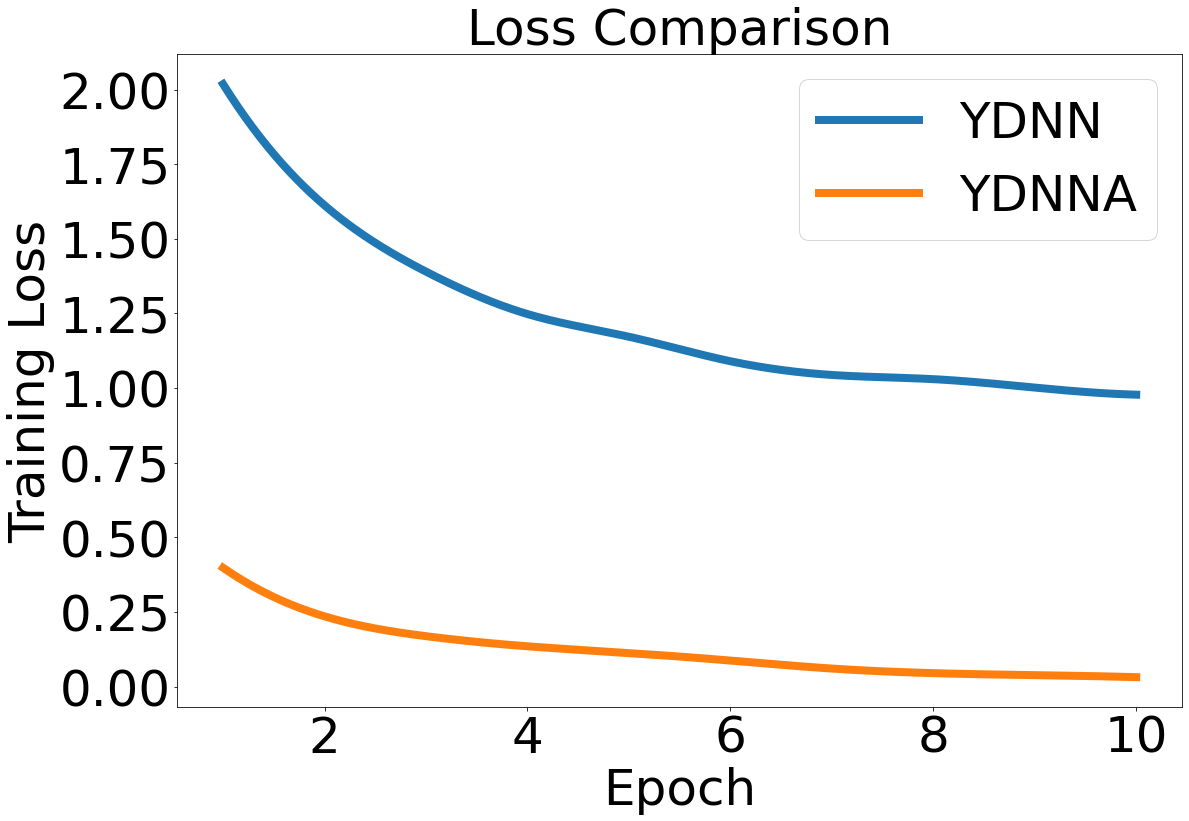

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18, 12))

plt.plot(xs, YDNN_avg_loss_smooth, label='YDNN', linewidth=8)
plt.plot(xs, YDNNA_avg_loss_smooth, label='YDNNA', linewidth=8)
plt.title("Loss Comparison",fontsize=50)
plt.xlabel("Epoch",fontsize=50)
plt.ylabel("Training Loss",fontsize=50)
plt.xticks(size = 50)
plt.yticks(size = 50)
plt.legend(prop={'size':50})
plt.savefig('Loss Comparison.png', dpi=300)
plt.show()
#

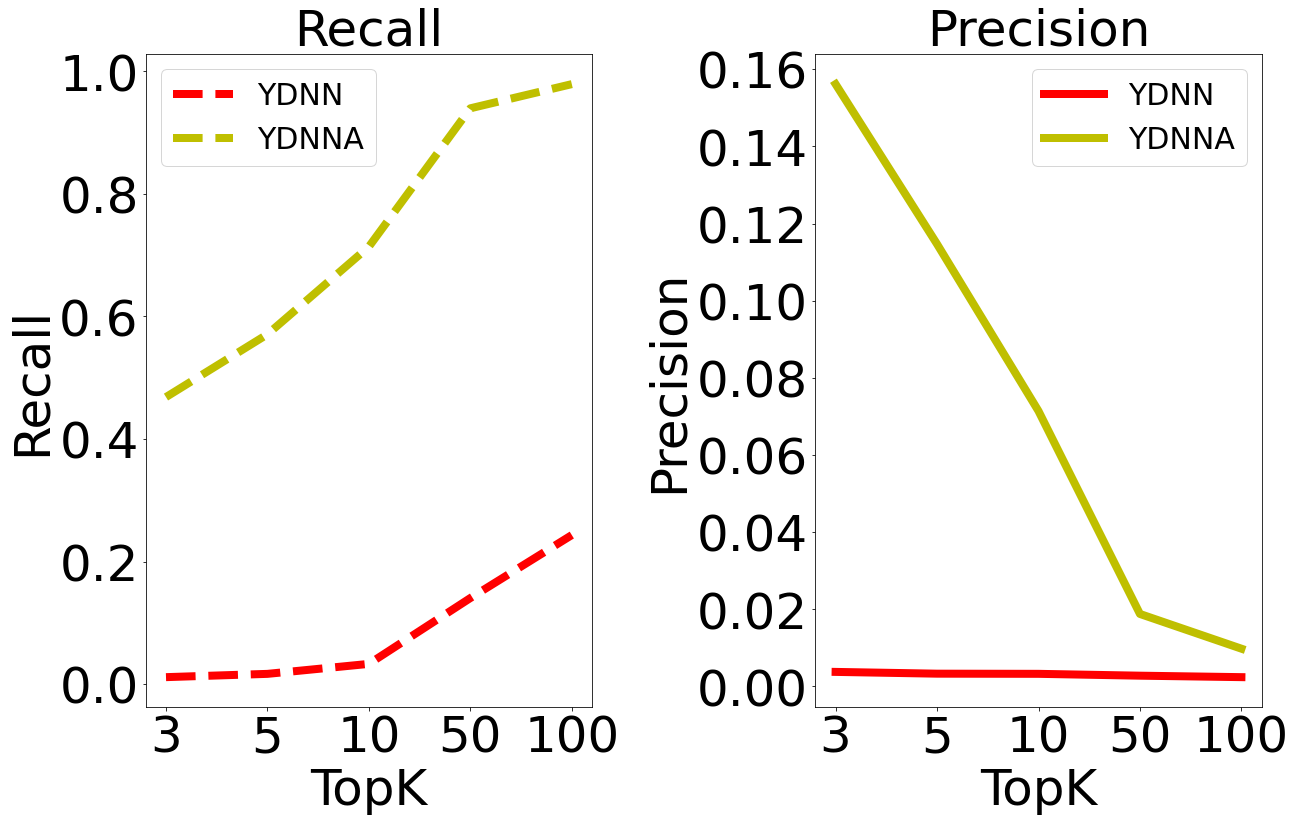

In [ ]:
import  matplotlib.pyplot as plt
import numpy as np 

plt.rcParams['axes.unicode_minus']=False 

x=[1, 2, 3, 4, 5]                    #虚假的x值，用来等间距分割
x_index=['3','5','10','50','100']  # x 轴显示的刻度
#x=np.array([3, 5, 10, 50, 100])
y1, y2 = YDNN_avg_recall, YDNNA_avg_recall
y3, y4 = YDNN_avg_precision, YDNNA_avg_precision
plt.figure(figsize=(20, 12))
plt.figure(1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(x, y1, color="r",linestyle = "--", label='YDNN', linewidth=8.0)
ax1.plot(x, y2,color="y", linestyle = "--", label='YDNNA', linewidth=8.0)
_ = plt.xticks(x,x_index)           # 显示坐标字
ax1.set_xlabel('TopK', fontsize=50)
ax1.set_ylabel('Recall', fontsize=50)
plt.xticks(size = 50)
plt.yticks(size = 50)
plt.legend(prop={'size':30})
plt.title('Recall', fontsize=50)



ax2 = plt.subplot(1, 2, 2)
ax2.plot(x, y3,color="r", linestyle = "-", label='YDNN', linewidth=8.0)
ax2.plot(x, y4,color="y", linestyle = "-", label='YDNNA', linewidth=8.0)
_ = plt.xticks(x,x_index)           # 显示坐标字
ax2.set_xlabel('TopK', fontsize=50)
ax2.set_ylabel('Precision', fontsize=50)
plt.xticks(size = 50)
plt.yticks(size = 50)
plt.legend(prop={'size':30})
plt.title('Precision', fontsize=50)

plt.savefig('MetricComparison', dpi=300)
plt.show()